In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\PC\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
# %% [markdown]
# # 03 - Entraînement LSTM sur séquences MFCC
#
# Objectif :
# - Charger les séquences MFCC (une fenêtre par fichier CSV)
# - Utiliser les labels associés depuis lstm_labels.csv
# - Entraîner un LSTM pour classifier les gestes
# - Évaluer l'accuracy, le rapport de classification et la matrice de confusion
# - Sauvegarder le modèle LSTM

# %%
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ===============================
# Chemins à ADAPTER si besoin
# ===============================

# Dossier contenant les fichiers window_XXXXX.csv
LSTM_DIR = r"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/Labels"

# Fichier CSV contenant les labels (une ligne par fenêtre)
LABELS_PATH = r"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/lstm_labels.csv"

# Dossier de sauvegarde des modèles
MODEL_DIR = r"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Dossier séquences LSTM :", LSTM_DIR)
print("Fichier labels LSTM    :", LABELS_PATH)
print("Dossier modèles        :", MODEL_DIR)

Dossier séquences LSTM : C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/Labels
Fichier labels LSTM    : C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/lstm_labels.csv
Dossier modèles        : C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/models


In [ ]:
# %%
# Paramètres d'entraînement
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3

# Si GPU dispo => on l'utilise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)



Device utilisé : cpu


In [12]:
class MFCCSequenceDataset(Dataset):
    """
    Dataset PyTorch qui :
    - lit window_XXXXX.csv dans un dossier (une séquence MFCC par fichier)
    - associe chaque séquence à un label depuis lstm_labels.csv
    """
    def __init__(self, seq_dir, labels_path):
        super().__init__()
        self.seq_dir = seq_dir

        # Charger les labels
        labels_df = pd.read_csv(labels_path)
        # On suppose que la colonne s'appelle 'label'
        assert "label" in labels_df.columns, "La colonne 'label' doit exister dans lstm_labels.csv"
        self.labels = labels_df["label"].values.astype(np.int64)

        # Lister les fichiers de séquences
        all_files = sorted(
            f for f in os.listdir(seq_dir)
            if f.endswith(".csv") and f.startswith("window_")
        )

        self.files = all_files

        # Vérification de la cohérence
        assert len(self.files) == len(self.labels), \
            f"Incohérence : {len(self.files)} fichiers trouvés, mais {len(self.labels)} labels."

        print(f"{len(self.files)} séquences chargées depuis {seq_dir}")
        print(f"{len(self.labels)} labels chargés depuis {labels_path}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Récupérer le chemin du fichier window_XXXXX.csv
        fname = self.files[idx]
        path = os.path.join(self.seq_dir, fname)

        # Charger la séquence MFCC (chaque ligne = un frame temporel, colonnes = features)
        df_seq = pd.read_csv(path)
        seq = df_seq.values.astype(np.float32)  # shape (T_frames, n_features)

        # Convertir en tenseurs PyTorch
        x = torch.from_numpy(seq)                  # (T, F)
        y = torch.tensor(self.labels[idx])         # scalaire (label)

        return x, y


In [13]:
# %%
# Instanciation du dataset complet
dataset = MFCCSequenceDataset(LSTM_DIR, LABELS_PATH)

# Vérification rapide sur un exemple
x0, y0 =dataset[0]
print("Shape séquence exemple :", x0.shape)  # (T_frames, n_features)
print("Label exemple          :", y0.item())

3084 séquences chargées depuis C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/Labels
3084 labels chargés depuis C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/lstm_labels.csv
Shape séquence exemple : torch.Size([9, 120])
Label exemple          : 0


In [14]:
# %%
# Split train / validation (80% / 20%)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

print("Taille train :", len(train_dataset))
print("Taille val   :", len(val_dataset))

Taille train : 2467
Taille val   : 617


In [21]:
class LSTMMFCCClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        # x = (batch, seq_len, input_size)

        out, (h_n, c_n) = self.lstm(x)

        if self.num_directions == 2:
            last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last_hidden = h_n[-1]

        logits = self.fc(last_hidden)
        return logits


In [22]:
# %%
# Récupérer la dimension d'entrée (nombre de features) et le nombre de classes
x_example, _ = dataset[0]
input_size = x_example.shape[1]  # nombre de colonnes dans window_XXXXX.csv
labels_df = pd.read_csv(LABELS_PATH)
num_classes = len(np.unique(labels_df["label"].values))

print("input_size  (features) :", input_size)
print("num_classes (gestes)   :", num_classes)

hidden_size = 64
num_layers = 1
bidirectional = False  # tu peux essayer True plus tard

model = LSTMMFCCClassifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes,
    bidirectional=bidirectional
).to(device)

print(model)

# %%
# Fonction de coût et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


input_size  (features) : 120
num_classes (gestes)   : 5
LSTMMFCCClassifier(
  (lstm): LSTM(120, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)


In [23]:
# %%
# Fonctions d'entraînement / évaluation
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for x_batch, y_batch in loader:
        # x_batch : liste de séquences, shape (batch, seq_len, input_size)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)  # (batch, num_classes)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc

In [24]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * x_batch.size(0)

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, np.array(all_labels), np.array(all_preds)

In [25]:
# %%
# Boucle d'entraînement sur plusieurs époques
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch:02d}] "
          f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

[Epoch 01] Train loss: 1.5848 | Train acc: 0.2655 | Val loss: 1.5515 | Val acc: 0.3339
[Epoch 02] Train loss: 1.5045 | Train acc: 0.4001 | Val loss: 1.4802 | Val acc: 0.3971
[Epoch 03] Train loss: 1.4116 | Train acc: 0.4714 | Val loss: 1.3963 | Val acc: 0.4344
[Epoch 04] Train loss: 1.3183 | Train acc: 0.5209 | Val loss: 1.3276 | Val acc: 0.4635
[Epoch 05] Train loss: 1.2144 | Train acc: 0.5797 | Val loss: 1.2668 | Val acc: 0.4959
[Epoch 06] Train loss: 1.1041 | Train acc: 0.6328 | Val loss: 1.1964 | Val acc: 0.5251
[Epoch 07] Train loss: 1.0141 | Train acc: 0.6814 | Val loss: 1.1465 | Val acc: 0.5365
[Epoch 08] Train loss: 0.9121 | Train acc: 0.7154 | Val loss: 1.0921 | Val acc: 0.5770
[Epoch 09] Train loss: 0.8179 | Train acc: 0.7641 | Val loss: 1.0490 | Val acc: 0.5802
[Epoch 10] Train loss: 0.7421 | Train acc: 0.7921 | Val loss: 1.0320 | Val acc: 0.5851
[Epoch 11] Train loss: 0.6572 | Train acc: 0.8330 | Val loss: 0.9505 | Val acc: 0.6402
[Epoch 12] Train loss: 0.5919 | Train acc: 

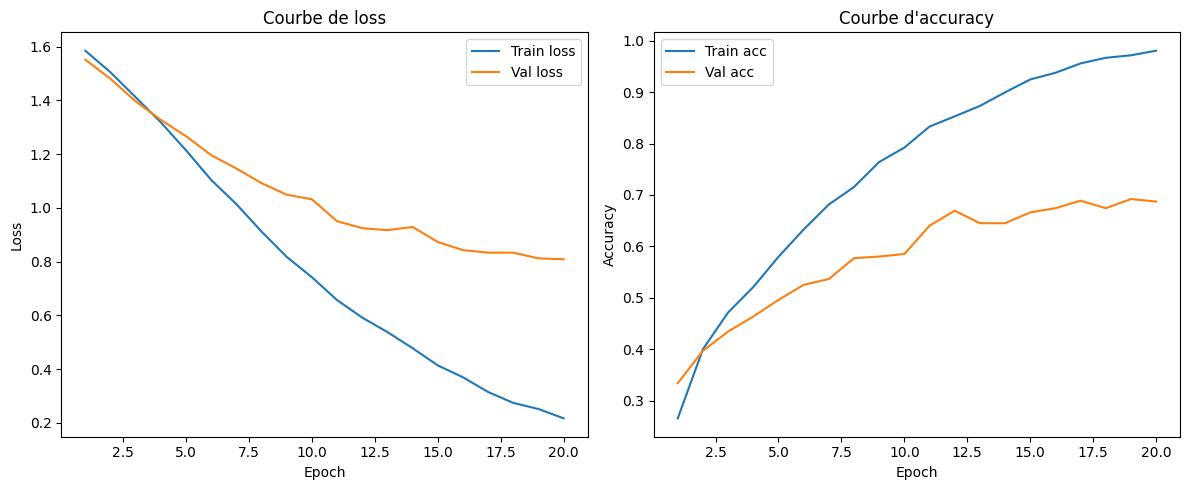

In [26]:
# %%
# Tracer les courbes de loss et d'accuracy
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train acc")
plt.plot(epochs_range, val_accs, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe d'accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# %%
# Évaluation finale sur le set de validation avec matrice de confusion
val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)

print(f"\n✅ Performance finale sur validation :")
print(f"Loss : {val_loss:.4f}")
print(f"Accuracy : {val_acc:.4f}")

print("\nClassification report (validation) :")
print(classification_report(y_true, y_pred))


✅ Performance finale sur validation :
Loss : 0.8089
Accuracy : 0.6872

Classification report (validation) :
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       126
           1       0.66      0.76      0.71        93
           2       0.68      0.68      0.68       142
           3       0.63      0.69      0.66       121
           4       0.66      0.50      0.57       135

    accuracy                           0.69       617
   macro avg       0.69      0.69      0.69       617
weighted avg       0.69      0.69      0.68       617



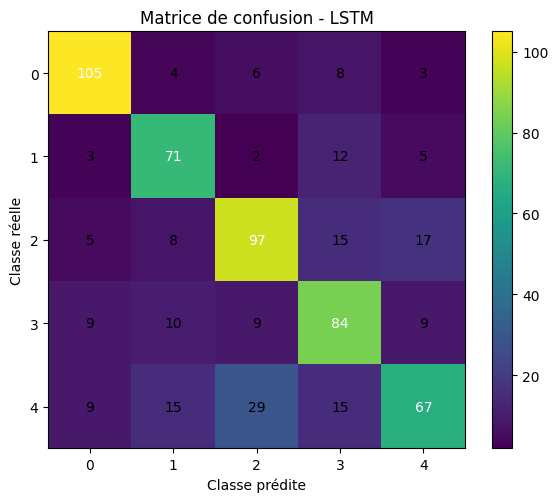

In [28]:
# %%
# Matrice de confusion pour le LSTM
cm = confusion_matrix(y_true, y_pred)
classes = np.unique(y_true)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion - LSTM")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        color = "white" if val > cm.max() / 2 else "black"
        plt.text(j, i, str(val), ha="center", va="center", color=color)

plt.tight_layout()
plt.show()



In [ ]:
# %%
# Sauvegarde du modèle LSTM
lstm_model_path = os.path.join(MODEL_DIR, "lstm_mfcc.pt")
torch.save(model.state_dict(), lstm_model_path)

print(f"✅ Modèle LSTM sauvegardé dans : {lstm_model_path}")